# Prediction Disagreement Analysis

## Moral Except QA Dataset

In [40]:
# imports
import os
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.manifold import MDS
from scipy.spatial.distance import squareform

##### Data Prep

In [5]:
# file mappings

## llama31
## llama32
## mistral
#______________
## phi
## olmo7b
## qwen
## deepseek
#______________
## olmo32b


llama31_files = {
    "English": "binary_eval_results_scenario_meta-llama_Llama-3_1-8B-Instruct.json",
    "Urdu": "binary_eval_results_Urdu_meta-llama_Llama-3_1-8B-Instruct.json",
    "Chinese": "binary_eval_results_Chinese_meta-llama_Llama-3_1-8B-Instruct.json",
    "Hindi": "binary_eval_results_Hindi_meta-llama_Llama-3_1-8B-Instruct.json",
    "Spanish": "binary_eval_results_Spanish_meta-llama_Llama-3_1-8B-Instruct.json",
    "German": "binary_eval_results_German_meta-llama_Llama-3_1-8B-Instruct.json"
}

llama32_files = {
    "English": "binary_eval_results_scenario_meta-llama_Llama-3_2-3B-Instruct.json",
    "Urdu": "binary_eval_results_Urdu_meta-llama_Llama-3_2-3B-Instruct.json",
    "Chinese": "binary_eval_results_Chinese_meta-llama_Llama-3_2-3B-Instruct.json",
    "Hindi": "binary_eval_results_Hindi_meta-llama_Llama-3_2-3B-Instruct.json",
    "Spanish": "binary_eval_results_Spanish_meta-llama_Llama-3_2-3B-Instruct.json",
    "German": "binary_eval_results_German_meta-llama_Llama-3_2-3B-Instruct.json"
}

mistral_files = {
    "English": "binary_eval_results_scenario_mistralai_Mistral-7B-Instruct-v0_3.json",
    "Urdu": "binary_eval_results_Urdu_mistralai_Mistral-7B-Instruct-v0_3.json",
    "Chinese": "binary_eval_results_Chinese_mistralai_Mistral-7B-Instruct-v0_3.json",
    "Hindi": "binary_eval_results_Hindi_mistralai_Mistral-7B-Instruct-v0_3.json",
    "Spanish": "binary_eval_results_Spanish_mistralai_Mistral-7B-Instruct-v0_3.json",
    "German": "binary_eval_results_German_mistralai_Mistral-7B-Instruct-v0_3.json"
}

phi_files = {
    "English": "binary_eval_results_scenario_microsoft_Phi-4-mini-instruct.json",
    "Urdu": "binary_eval_results_Urdu_microsoft_Phi-4-mini-instruct.json",
    "Chinese": "binary_eval_results_Chinese_microsoft_Phi-4-mini-instruct.json",
    "Hindi": "binary_eval_results_Hindi_microsoft_Phi-4-mini-instruct.json",
    "Spanish": "binary_eval_results_Spanish_microsoft_Phi-4-mini-instruct.json",
    "German": "binary_eval_results_German_microsoft_Phi-4-mini-instruct.json"
}

olmo7b_files = {
    "English": "binary_eval_results_scenario_allenai_OLMo-7B-Instruct.json",
    "Urdu": "binary_eval_results_Urdu_allenai_OLMo-7B-Instruct.json",
    "Chinese": "binary_eval_results_Chinese_allenai_OLMo-7B-Instruct.json",
    "Hindi": "binary_eval_results_Hindi_allenai_OLMo-7B-Instruct.json",
    "Spanish": "binary_eval_results_Spanish_allenai_OLMo-7B-Instruct.json",
    "German": "binary_eval_results_German_allenai_OLMo-7B-Instruct.json"
}

qwen_files = {
    "English": "binary_eval_results_scenario_Qwen_Qwen2_5-7B-Instruct.json",
    "Urdu": "binary_eval_results_Urdu_Qwen_Qwen2_5-7B-Instruct.json",
    "Chinese": "binary_eval_results_Chinese_Qwen_Qwen2_5-7B-Instruct.json",
    "Hindi": "binary_eval_results_Hindi_Qwen_Qwen2_5-7B-Instruct.json",
    "Spanish": "binary_eval_results_Spanish_Qwen_Qwen2_5-7B-Instruct.json",
    "German": "binary_eval_results_German_Qwen_Qwen2_5-7B-Instruct.json"
}

deepseek_files = {
    "English": "binary_eval_results_scenario_deepseek-ai_DeepSeek-R1-Distill-Llama-8B.json",
    "Urdu": "parsed_binary_eval_results_Urdu_deepseek-ai_DeepSeek-R1-Distill-Llama-8B.json",
    "Chinese": "parsed_binary_eval_results_Chinese_deepseek-ai_DeepSeek-R1-Distill-Llama-8B.json",
    "Hindi": "parsed_binary_eval_results_Hindi_deepseek-ai_DeepSeek-R1-Distill-Llama-8B.json",
    "Spanish": "binary_eval_results_Spanish_deepseek-ai_DeepSeek-R1-Distill-Llama-8B.json",
    "German": "binary_eval_results_German_deepseek-ai_DeepSeek-R1-Distill-Llama-8B.json"
}

olmo32b_files = {
    "English": "binary_eval_results_scenario_allenai_OLMo-2-0325-32B-Instruct.json",
    "Urdu": "binary_eval_results_Urdu_allenai_OLMo-2-0325-32B-Instruct.json",
    "Chinese": "binary_eval_results_Chinese_allenai_OLMo-2-0325-32B-Instruct.json",
    "Hindi": "binary_eval_results_Hindi_allenai_OLMo-2-0325-32B-Instruct.json",
    "Spanish": "binary_eval_results_Spanish_allenai_OLMo-2-0325-32B-Instruct.json",
    "German": "binary_eval_results_German_allenai_OLMo-2-0325-32B-Instruct.json"
}

In [3]:
def build_csv(file_map, output_csv, base_dir=None):
    df_all = pd.DataFrame()
    
    for lang_code, path in file_map.items():
        full_path = os.path.join(base_dir, path) if base_dir else path
        df = pd.read_json(full_path)

        # Dynamically determine the correct question column
        if "scenario" in df.columns:
            question_key = "scenario"
        elif "question" in df.columns:
            question_key = "question"
        else:
            raise ValueError(f"Neither 'scenario' nor 'question' found in {full_path}")

        if df_all.empty:
            df_all["question"] = df[question_key]
            df_all["reference"] = df["reference"]

        df_all[lang_code] = df["parsed_answer"]
    
    df_all.to_csv(output_csv, index=False, encoding='utf-8')
    print(f"Saved: {output_csv} (rows: {len(df_all)})")
    return df_all

In [6]:
# Make sure the output directory exists
combined_output_dir = "MEQ_combined_results"
os.makedirs(combined_output_dir, exist_ok=True)

model_file_maps = {
    "llama31": llama31_files,
    "llama32": llama32_files,
    "mistral": mistral_files,
    "phi": phi_files,
    "olmo7b": olmo7b_files,
    "qwen": qwen_files,
    "deepseek": deepseek_files,
    "olmo32b": olmo32b_files
}

# get the combined files
for model_name, file_map in model_file_maps.items():
    output_csv = os.path.join(combined_output_dir, f"meq_{model_name}_predictions_combined.csv")

    if model_name == "olmo32b":
        build_csv(file_map, output_csv, base_dir = "MEQ_OLMo2_Result")
    else:
        build_csv(file_map, output_csv, base_dir = "MEQ_Results")

Saved: MEQ_combined_results/meq_llama31_predictions_combined.csv (rows: 148)
Saved: MEQ_combined_results/meq_llama32_predictions_combined.csv (rows: 148)
Saved: MEQ_combined_results/meq_mistral_predictions_combined.csv (rows: 148)
Saved: MEQ_combined_results/meq_phi_predictions_combined.csv (rows: 148)
Saved: MEQ_combined_results/meq_olmo7b_predictions_combined.csv (rows: 148)
Saved: MEQ_combined_results/meq_qwen_predictions_combined.csv (rows: 148)
Saved: MEQ_combined_results/meq_deepseek_predictions_combined.csv (rows: 148)
Saved: MEQ_combined_results/meq_olmo32b_predictions_combined.csv (rows: 148)


##### Prediction Disagreement Matrices

In [43]:
# creates matrix

def disagreement_matrix_symmetric(df, pred_cols):
    matrix = pd.DataFrame(index=pred_cols, columns=pred_cols, dtype=int)

    for i in pred_cols:
        for j in pred_cols:
            if i == j:
                matrix.loc[i, j] = 0
            else:
                matrix.loc[i, j] = (df[i] != df[j]).sum()
    
    return matrix

# creates visual
def plot_disagreement_heatmap(disagreement_df, title="Prediction Disagreement Matrix", save_path=None, show=False):
    plt.figure(figsize=(6, 6))
    sns.heatmap(
        disagreement_df.astype(int), 
        annot=True, 
        fmt="d", 
        cmap="YlGnBu", 
        linewidths=0.5, 
        square=True,
        cbar_kws={"label": "Disagreement Count"}
    )
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    if show:
        plt.show()

    plt.close()

cols = ["English", "Urdu", "Chinese", "Hindi", "Spanish", "German"]

In [44]:
os.makedirs("disagreement_plots/MEQ", exist_ok=True)

combined_dir = "MEQ_combined_results"
all_matrices = {}

# List all relevant combined CSVs
for fname in os.listdir(combined_dir):
    if not fname.endswith("_predictions_combined.csv"):
        continue
    
    path = os.path.join(combined_dir, fname)
    df = pd.read_csv(path)

    lang_cols = [col for col in df.columns if col not in ["question", "reference"]]
    if not lang_cols:
        continue

    mat = disagreement_matrix_symmetric(df, lang_cols)
    mat_df = pd.DataFrame(mat, index=lang_cols, columns=lang_cols)

    base = fname.replace("_predictions_combined.csv", "")
    parts = base.split("_")
    paradigm = parts[0]
    model = "_".join(parts[1:])

    if paradigm not in all_matrices:
        all_matrices[paradigm] = {}
    all_matrices[paradigm][model] = mat_df

    # Save the heatmap directly
    plot_path = f"disagreement_plots/MEQ/{base}_heatmap.png"
    plot_disagreement_heatmap(
        mat_df, 
        title=f'PDM - {base}',
        save_path=plot_path,
        show=False  # set to True if you want interactive viewing
    )


##### Clustering and Patterns

**Multidimensional Scaling (MDS)**

MDS plots for our work would visualise how similarly different language-specific LLM predictions behave by mapping their pairwise disagreement distances into 2D space - it highlights which languages align in model behavior and which ones diverge, offering insight into cross-lingual consistency and reliability.

Distance matrix = disagreement matrix

In [9]:
def plot_mds(disagreement_df, title="MDS of Prediction Disagreement", save_path=None, show=False):
    mds = MDS(dissimilarity="precomputed", random_state=42)
    coords = mds.fit_transform(disagreement_df.values)
    df_mds = pd.DataFrame(coords, index=disagreement_df.index, columns=["x", "y"])
    
    plt.figure(figsize=(6, 5))
    sns.scatterplot(data=df_mds, x="x", y="y", hue=df_mds.index, s=100, legend=False)
    
    for label, row in df_mds.iterrows():
        plt.text(row.x + 0.01, row.y + 0.01, label)
    
    plt.title(title)
    plt.axis("equal")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    if show:
        plt.show()
    
    plt.close()

In [10]:
os.makedirs("disagreement_plots/MEQ", exist_ok=True)

combined_dir = "MEQ_combined_results"

for fname in os.listdir(combined_dir):
    if not fname.endswith("_predictions_combined.csv"):
        continue

    path = os.path.join(combined_dir, fname)
    df = pd.read_csv(path)

    lang_cols = [col for col in df.columns if col not in ["question", "reference"]]
    if not lang_cols:
        continue

    mat = disagreement_matrix_symmetric(df, lang_cols)
    mat_df = pd.DataFrame(mat, index=lang_cols, columns=lang_cols)

    plot_path = f"disagreement_plots/MEQ/{fname.replace('_predictions_combined.csv', '')}_mds.png"

    plot_mds(
        mat_df, 
        title=f'MDS - {fname.replace("_predictions_combined.csv", "")}',
        save_path=plot_path,
        show=False
    )


Takeaways:

- Potential relatively higher-resource alignment: English, German, and Chinese often form tight cores.

- Hindi and Urdu consistently break from the cluster which may indicate: cultural framing mismatch, poor translation quality, or less consistent reasoning behavior in LLMs

- Model behavior shifts: LLaMA 3.2 causes English to behave differently from 3.1, and Mistral reinforces Urdu/Hindi as the least aligned.-

**Hierarchical Clustering (Agglomerative)**

Another way to visualise which languages behave similarly - this time using a dendrogram.

In [11]:
def plot_dendrogram(disagreement_df, title="Language Clustering (Disagreement)", save_path=None, show=False):
    # Convert to condensed distance matrix
    condensed = squareform(disagreement_df.values)
    linkage_matrix = linkage(condensed, method="ward")
    
    plt.figure(figsize=(8, 5))
    dendrogram(linkage_matrix, labels=disagreement_df.index.tolist())
    plt.title(title)
    plt.ylabel("Distance")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    if show:
        plt.show()
    
    plt.close()

In [12]:
os.makedirs("disagreement_plots/MEQ", exist_ok=True)

combined_dir = "MEQ_combined_results"

for fname in os.listdir(combined_dir):
    if not fname.endswith("_predictions_combined.csv"):
        continue

    path = os.path.join(combined_dir, fname)
    df = pd.read_csv(path)

    lang_cols = [col for col in df.columns if col not in ["question", "reference"]]
    if not lang_cols:
        continue

    mat = disagreement_matrix_symmetric(df, lang_cols)
    mat_df = pd.DataFrame(mat, index=lang_cols, columns=lang_cols)

    plot_path = f"disagreement_plots/MEQ/{fname.replace('_predictions_combined.csv', '')}_dendrogram.png"
    
    plot_dendrogram(
        mat_df, 
        title=f'Dendrogram - {fname.replace("_predictions_combined.csv", "")}',
        save_path=plot_path,
        show=False  # Set to True if you want to display as well
    )


Takeaways: 

- Consistent Clustering: English, German, Chinese, and Spanish form a relatively stable agreement group across models.

- Outlier Behavior: Urdu and Hindi consistently behave as outliers — either due to translation variation, low-resource alignment, or cultural framing issues in LLMs.

- Model Differences: LLaMA 3.1 seems more stable than 3.2 in handling English. Mistral appears to treat Urdu and Hindi as significantly more divergent than LLaMA models do.



### Consolidated MEQ PLOTS

In [13]:
os.makedirs("disagreement_plots/MEQ", exist_ok=True)

for paradigm, model_dict in all_matrices.items():
    mats = list(model_dict.values())
    if not mats:
        continue
    
    # Find common languages
    lang_sets = [set(m.index) for m in mats]
    common_langs = set.intersection(*lang_sets)
    if not common_langs:
        continue
    common_langs = sorted(list(common_langs))

    # Restrict all matrices to common languages
    mats_common = [m.loc[common_langs, common_langs] for m in mats]
    
    # Compute mean disagreement matrix
    mean_mat = np.mean([m.values for m in mats_common], axis=0)
    mean_df = pd.DataFrame(mean_mat, index=common_langs, columns=common_langs)

    # Plot and save heatmap
    plot_disagreement_heatmap(
        mean_df, 
        title=f"Consolidated Disagreement - {paradigm}",
        save_path=f"disagreement_plots/MEQ/consolidated_{paradigm}_matrix.png"
    )

    # Plot and save MDS
    plot_mds(
        mean_df, 
        title=f"Consolidated MDS - {paradigm}",
        save_path=f"disagreement_plots/MEQ/consolidated_{paradigm}_mds.png"
    )

    # Plot and save dendrogram
    plot_dendrogram(
        mean_df, 
        title=f"Consolidated Dendrogram - {paradigm}",
        save_path=f"disagreement_plots/MEQ/consolidated_{paradigm}_dendrogram.png"
    )


## ETHICS Dataset

#### Data Prep

In [17]:
ethics_file_map = {}

def add_to_map(paradigm, model, language, path):
    if paradigm not in ethics_file_map:
        ethics_file_map[paradigm] = {}
    if model not in ethics_file_map[paradigm]:
        ethics_file_map[paradigm][model] = {}
    ethics_file_map[paradigm][model][language] = path

# --- SF ---
if os.path.isdir('ETHICS_Results_sf'):
    for fname in os.listdir('ETHICS_Results_sf'):
        m = re.match(r'para_([a-zA-Z_]+)_([a-zA-Z]+)_results_(.+)\.json', fname)
        if m:
            paradigm, language, model = m.groups()
            add_to_map(paradigm, model, language, f'ETHICS_Results_sf/{fname}')

# --- J ---
if os.path.isdir('ETHICS_Results_j'):
    for fname in os.listdir('ETHICS_Results_j'):
        m = re.match(r'(fixed_)?para_([a-zA-Z_]+)_([a-zA-Z]+)_results_(.+)\.json', fname)
        if m:
            paradigm, language, model = m.group(2), m.group(3), m.group(4)
            add_to_map(paradigm, model, language, f'ETHICS_Results_j/{fname}')

# --- Z ---

languages = ["English", "Chinese", "Urdu", "Hindi", "Spanish", "German"]
lang_regex = "|".join(languages)
if os.path.isdir('ETHICS_Results_z'):
    for fname in os.listdir('ETHICS_Results_z'):
        m = re.match(rf'ethics_([a-zA-Z_]+)_({lang_regex})_(.+)\.json', fname)
        if m:
            paradigm, language, model = m.groups()
            add_to_map(paradigm, model, language, f'ETHICS_Results_z/{fname}')

# Example usage:
# ethics_file_map["den"]["meta_llama_Llama_3_1_8B_Instruct"]["English"]
# ethics_file_map["den"]["allenai_OLMo_2_0325_32B_Instruct"]["English"]
# ethics_file_map["virtue"]["deepseek-ai_DeepSeek-R1-Distill-Llama-8B"]["Urdu"]
# print(list(ethics_file_map["cms"]["Qwen_Qwen2_5-7B-Instruct"].keys()))
# print(list(ethics_file_map["cms"].keys()))
print(list(ethics_file_map["cms"]["Qwen_Qwen2_5-7B-Instruct"].keys()))

['Spanish', 'German', 'Hindi', 'Chinese', 'English', 'Urdu']


In [18]:
def robust_read_ethics_json(path):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    # If the file is a dict with a "results" key, use that
    if isinstance(data, dict) and "results" in data:
        return pd.DataFrame(data["results"])
    # If it's already a list, just use it
    elif isinstance(data, list):
        return pd.DataFrame(data)
    # If it's a dict of lists, try to convert
    elif isinstance(data, dict):
        return pd.DataFrame(data)
    else:
        raise ValueError(f"Unrecognized JSON structure in {path}")

def build_ethics_csv(paradigm, model, file_map, output_csv):
    df_all = pd.DataFrame()
    for lang, path in file_map[paradigm][model].items():
        df = robust_read_ethics_json(path)
        # Try to find the question key
        question_key = None
        for candidate in ["scenario", "question"]:
            if candidate in df.columns:
                question_key = candidate
                break
        if question_key is None:
            raise ValueError(f"No question/scenario column in {path}")
        if df_all.empty:
            df_all["question"] = df[question_key]
            # Reference logic
            if "reference" in df.columns:
                df_all["reference"] = df["reference"]
            elif "util" in path:
                df_all["reference"] = 1
        df_all[lang] = df["parsed_answer"]
    df_all.to_csv(output_csv, index=False, encoding='utf-8')
    print(f"Saved: {output_csv} (rows: {len(df_all)})")
    return df_all

# Create output directory if it doesn't exist
os.makedirs("ETHICS_combined_results", exist_ok=True)

# Save combined CSVs for all paradigm/model pairs (except Qwen and DeepSeek models)
for paradigm in ethics_file_map:
    for model in ethics_file_map[paradigm]:
        # if ("qwen" in model.lower()) or ("deepseek" in model.lower()):
        #     continue
        output_csv = f"ETHICS_combined_results/{paradigm}_{model}_predictions_combined.csv"
        build_ethics_csv(paradigm, model, ethics_file_map, output_csv)

Saved: ETHICS_combined_results/virtue_meta_llama_Llama_3_1_8B_Instruct_predictions_combined.csv (rows: 4975)
Saved: ETHICS_combined_results/virtue_meta_llama_Llama_3_2_3B_Instruct_predictions_combined.csv (rows: 4975)
Saved: ETHICS_combined_results/virtue_microsoft_Phi_4_mini_instruct_predictions_combined.csv (rows: 4975)
Saved: ETHICS_combined_results/virtue_mistralai_Mistral_7B_Instruct_v0_3_predictions_combined.csv (rows: 4975)
Saved: ETHICS_combined_results/virtue_allenai_OLMo_2_0325_32B_Instruct_predictions_combined.csv (rows: 4975)
Saved: ETHICS_combined_results/virtue_allenai_OLMo_7B_Instruct_predictions_combined.csv (rows: 4975)
Saved: ETHICS_combined_results/virtue_deepseek-ai_DeepSeek-R1-Distill-Llama-8B_predictions_combined.csv (rows: 4976)
Saved: ETHICS_combined_results/virtue_Qwen_Qwen2_5-7B-Instruct_predictions_combined.csv (rows: 4976)
Saved: ETHICS_combined_results/justice_meta_llama_Llama_3_2_3B_Instruct_predictions_combined.csv (rows: 2704)
Saved: ETHICS_combined_resu

#### Prediction Disagreement Matrices

In [45]:
os.makedirs("disagreement_plots", exist_ok=True)

combined_dir = "ETHICS_combined_results"


# List all relevant combined CSVs
for fname in os.listdir(combined_dir):
    if not fname.endswith("_predictions_combined.csv"):
        continue
    
    path = os.path.join(combined_dir, fname)
    df = pd.read_csv(path)

    lang_cols = [col for col in df.columns if col not in ["question", "reference"]]
    if not lang_cols:
        continue

    mat = disagreement_matrix_symmetric(df, lang_cols)
    mat_df = pd.DataFrame(mat, index=lang_cols, columns=lang_cols)

    base = fname.replace("_predictions_combined.csv", "")
    parts = base.split("_")
    paradigm = parts[0]
    model = "_".join(parts[1:])

    if paradigm not in all_matrices:
        all_matrices[paradigm] = {}
    all_matrices[paradigm][model] = mat_df

    # Save the heatmap directly
    plot_path = f"disagreement_plots/{base}_heatmap.png"
    plot_disagreement_heatmap(
        mat_df, 
        title=f'PDM - {base}',
        save_path=plot_path,
        show=False  # set to True if you want interactive viewing
    )


#### Clustering and Patterns

Multi-dim scaling plots

In [18]:
os.makedirs("disagreement_plots", exist_ok=True)

combined_dir = "ETHICS_combined_results"

for fname in os.listdir(combined_dir):
    if not fname.endswith("_predictions_combined.csv"):
        continue

    path = os.path.join(combined_dir, fname)
    df = pd.read_csv(path)

    lang_cols = [col for col in df.columns if col not in ["question", "reference"]]
    if not lang_cols:
        continue

    mat = disagreement_matrix_symmetric(df, lang_cols)
    mat_df = pd.DataFrame(mat, index=lang_cols, columns=lang_cols)

    plot_path = f"disagreement_plots/{fname.replace('_predictions_combined.csv', '')}_mds.png"

    plot_mds(
        mat_df, 
        title=f'MDS - {fname.replace("_predictions_combined.csv", "")}',
        save_path=plot_path,
        show=False  # set to True if you want to display
    )


Hierarchical Clustering

In [17]:
os.makedirs("disagreement_plots", exist_ok=True)

combined_dir = "ETHICS_combined_results"

for fname in os.listdir(combined_dir):
    if not fname.endswith("_predictions_combined.csv"):
        continue

    path = os.path.join(combined_dir, fname)
    df = pd.read_csv(path)

    lang_cols = [col for col in df.columns if col not in ["question", "reference"]]
    if not lang_cols:
        continue

    mat = disagreement_matrix_symmetric(df, lang_cols)
    mat_df = pd.DataFrame(mat, index=lang_cols, columns=lang_cols)

    plot_path = f"disagreement_plots/{fname.replace('_predictions_combined.csv', '')}_dendrogram.png"
    
    plot_dendrogram(
        mat_df, 
        title=f'Dendrogram - {fname.replace("_predictions_combined.csv", "")}',
        save_path=plot_path,
        show=False  # Set to True if you want to display as well
    )


### Consolidated Ethics Plots

In [16]:
os.makedirs("disagreement_plots", exist_ok=True)

for paradigm, model_dict in all_matrices.items():
    mats = list(model_dict.values())
    if not mats:
        continue
    
    # Find common languages
    lang_sets = [set(m.index) for m in mats]
    common_langs = set.intersection(*lang_sets)
    if not common_langs:
        continue
    common_langs = sorted(list(common_langs))

    # Restrict all matrices to common languages
    mats_common = [m.loc[common_langs, common_langs] for m in mats]
    
    # Compute mean disagreement matrix
    mean_mat = np.mean([m.values for m in mats_common], axis=0)
    mean_df = pd.DataFrame(mean_mat, index=common_langs, columns=common_langs)

    # Plot and save heatmap
    plot_disagreement_heatmap(
        mean_df, 
        title=f"Consolidated Disagreement - {paradigm}",
        save_path=f"disagreement_plots/consolidated_{paradigm}_matrix.png"
    )

    # Plot and save MDS
    plot_mds(
        mean_df, 
        title=f"Consolidated MDS - {paradigm}",
        save_path=f"disagreement_plots/consolidated_{paradigm}_mds.png"
    )

    # Plot and save dendrogram
    plot_dendrogram(
        mean_df, 
        title=f"Consolidated Dendrogram - {paradigm}",
        save_path=f"disagreement_plots/consolidated_{paradigm}_dendrogram.png"
    )


### Consolidated Clustered Heatmaps with two datasets in each 

In [46]:
all_matrices

{'meq': {'llama32':          English   Urdu  Chinese  Hindi  Spanish  German
  English      0.0  110.0    113.0  113.0    108.0   103.0
  Urdu       110.0    0.0     88.0   85.0     94.0    89.0
  Chinese    113.0   88.0      0.0   71.0     75.0    67.0
  Hindi      113.0   85.0     71.0    0.0     81.0    69.0
  Spanish    108.0   94.0     75.0   81.0      0.0    79.0
  German     103.0   89.0     67.0   69.0     79.0     0.0,
  'olmo7b':          English   Urdu  Chinese  Hindi  Spanish  German
  English      0.0  148.0    148.0  148.0     90.0   148.0
  Urdu       148.0    0.0    131.0  115.0    148.0    97.0
  Chinese    148.0  131.0      0.0  130.0    148.0   121.0
  Hindi      148.0  115.0    130.0    0.0    148.0   107.0
  Spanish     90.0  148.0    148.0  148.0      0.0   148.0
  German     148.0   97.0    121.0  107.0    148.0     0.0,
  'olmo32b':          English  Urdu  Chinese  Hindi  Spanish  German
  English      0.0  53.0     57.0   58.0     36.0    36.0
  Urdu        53.

Plotting Common Sense (upper) vs Deontology (lower)


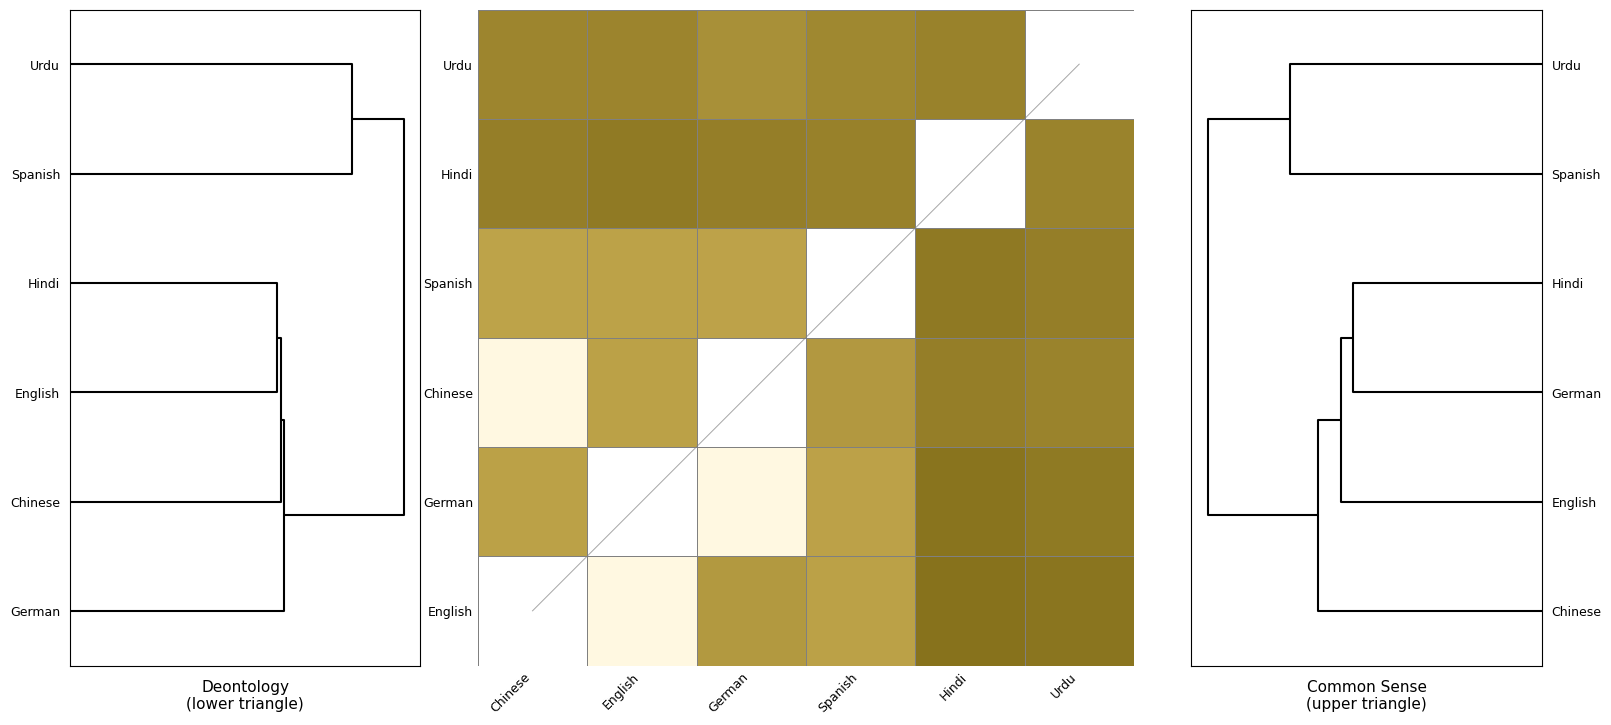

Plotting Utilitarianism (upper) vs Justice (lower)


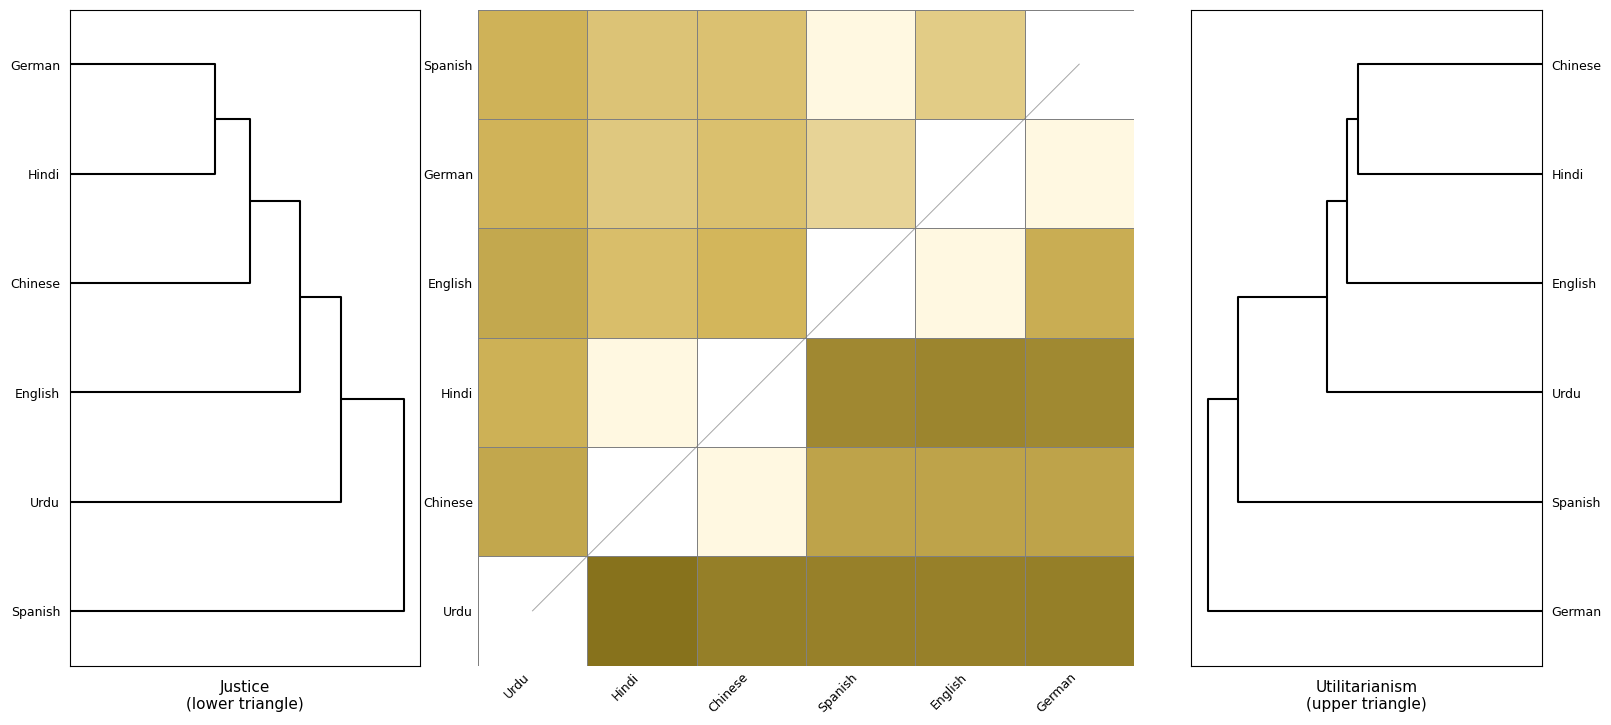

Plotting Virtue Ethics (upper) vs Moral Equality (lower)


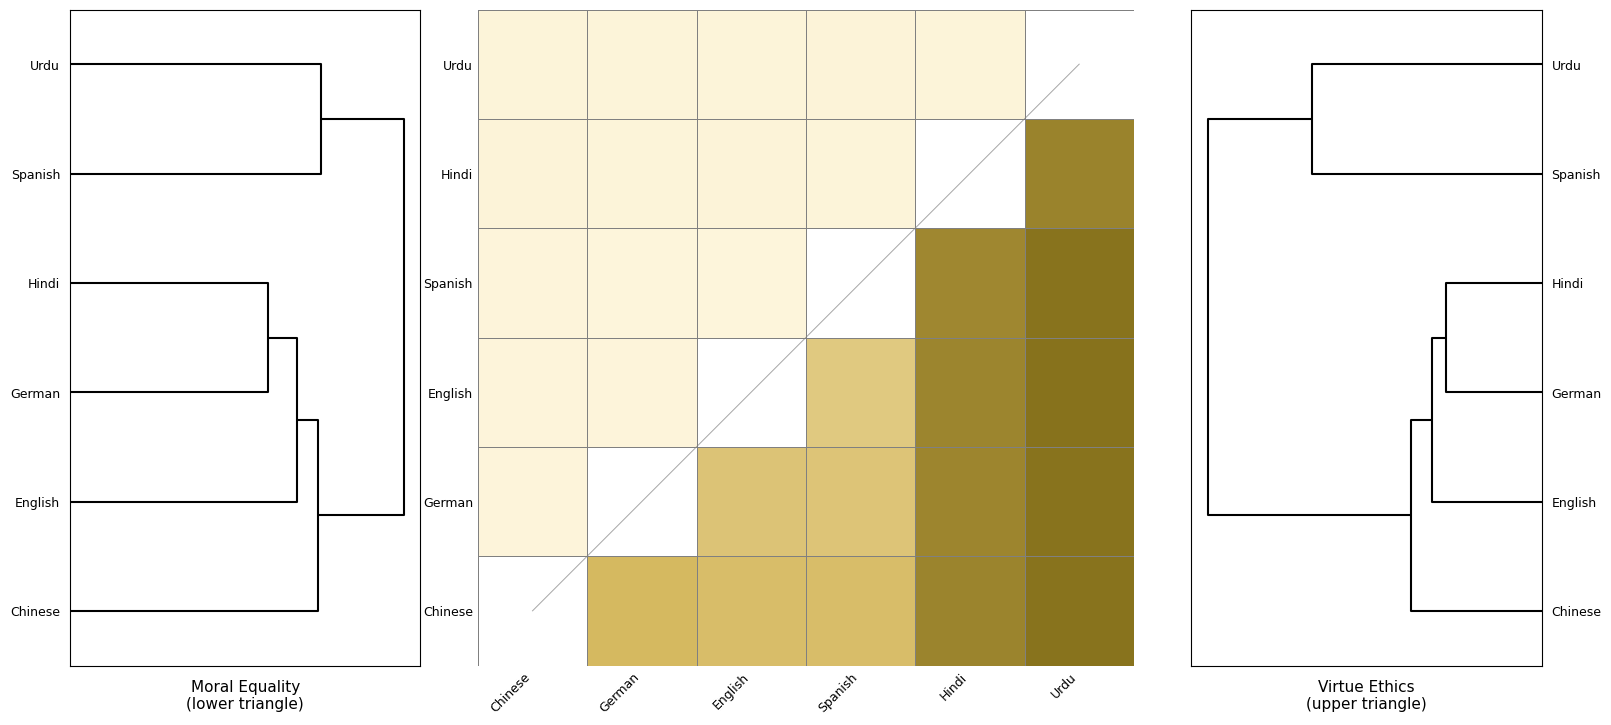

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram
from scipy.spatial.distance import squareform

# --- Golden colormap ---
cmap_custom = LinearSegmentedColormap.from_list(
    "golden", ["#fff8e1", "#d4b75c", "#87721C"]
)

# --- Full paradigm names for captions ---
paradigm_labels = {
    "den": "Deontology",
    "cms": "Common Sense",
    "util": "Utilitarianism",
    "justice": "Justice",
    "virtue": "Virtue Ethics",
    "meq": "Moral Equality",
}

# -------------------------------
# STEP 1: consolidate across models (same as before)
# -------------------------------
all_matrices_consolidated = {}
for paradigm, model_dict in all_matrices.items():
    mats = [m for m in model_dict.values() if hasattr(m, "values")]
    if not mats:
        continue
    all_matrices_consolidated[paradigm] = sum(mats) / len(mats)

# -------------------------------
# STEP 2: plotting (two distinct dendrograms; heatmap aligned)
# -------------------------------
def plot_split_heatmap_two_dendros(df_cols, df_rows, p_cols, p_rows,
                                   method="ward", cmap=cmap_custom):
    """
    df_cols -> defines column order & right dendrogram (upper triangle).
    df_rows -> defines row order   & left dendrogram (lower triangle).

    Heatmap is re-ordered: rows by df_rows linkage, columns by df_cols linkage.
    Upper triangle shows df_cols values; lower triangle shows df_rows values.
    """
    # --- compute separate orders ---
    Z_cols = linkage(squareform(df_cols.values, checks=False), method=method)
    Z_rows = linkage(squareform(df_rows.values, checks=False), method=method)
    col_order = leaves_list(Z_cols)
    row_order = leaves_list(Z_rows)
    col_labels = df_cols.index[col_order]
    row_labels = df_rows.index[row_order]

    # --- reorder matrices & combine triangles ---
    A = df_cols.loc[row_labels, col_labels].values   # to fill UPPER
    B = df_rows.loc[row_labels, col_labels].values   # to fill LOWER
    M = np.full_like(A, np.nan, dtype=float)
    iu = np.triu_indices_from(M, k=1)
    il = np.tril_indices_from(M, k=-1)
    M[iu] = A[iu]
    M[il] = B[il]
    np.fill_diagonal(M, np.nan)

    # dynamic color scaling (handles counts or ratios)
    vmax = np.nanmax(M)
    if not np.isfinite(vmax) or vmax == 0:
        vmax = 1.0

    # --- layout: wider dendrogram panes so labels don't clip ---
    fig = plt.figure(figsize=(16, 8))
    gs = fig.add_gridspec(1, 3, width_ratios=[2.8, 6, 2.8], wspace=0.02)

    # LEFT dendrogram = rows = p_rows
    axL = fig.add_subplot(gs[0, 0])
    dendrogram(
        Z_rows, labels=row_labels, orientation="right", ax=axL,
        color_threshold=0, above_threshold_color="black",
        leaf_font_size=9, leaf_rotation=0
    )
    axL.set_xticks([])
    axL.tick_params(axis="y", labelsize=9)
    axL.margins(x=0.12)
    axL.set_xlabel(f"{paradigm_labels.get(p_rows, p_rows)}\n(lower triangle)",
                   fontsize=11, labelpad=10)

    # HEATMAP
    axM = fig.add_subplot(gs[0, 1])
    im = axM.pcolormesh(
        M, cmap=cmap, vmin=0, vmax=vmax,  # auto-vmax
        edgecolors="gray", linewidth=0.5
    )
    nrows, ncols = M.shape
    axM.set_xticks(np.arange(ncols) + 0.5)
    axM.set_yticks(np.arange(nrows) + 0.5)
    axM.set_xticklabels(col_labels, rotation=45, ha="right", fontsize=9)
    axM.set_yticklabels(row_labels, fontsize=9)
    axM.tick_params(axis="both", which="both", length=0)
    axM.set_aspect("equal")
    # diagonal separator (cell centers)
    axM.plot(np.arange(min(nrows, ncols)) + 0.5,
             np.arange(min(nrows, ncols)) + 0.5,
             color="gray", lw=0.7, alpha=0.7)
    for s in ["top", "right", "left", "bottom"]:
        axM.spines[s].set_visible(False)

    # RIGHT dendrogram = cols = p_cols
    axR = fig.add_subplot(gs[0, 2])
    dendrogram(
        Z_cols, labels=col_labels, orientation="left", ax=axR,
        color_threshold=0, above_threshold_color="black",
        leaf_font_size=9, leaf_rotation=0
    )
    axR.set_xticks([])
    axR.tick_params(axis="y", labelsize=9)
    axR.margins(x=0.12)
    axR.set_xlabel(f"{paradigm_labels.get(p_cols, p_cols)}\n(upper triangle)",
                   fontsize=11, labelpad=10)

    fig.subplots_adjust(left=0.05, right=0.97, bottom=0.14, top=0.96, wspace=0.02)
    plt.show()

# -------------------------------
# Drive the three plots
# -------------------------------
pairs = [
    ("cms", "den"),       # right/upper = cms, left/lower = den
    ("util", "justice"),
    ("virtue", "meq"),
]

for p_cols, p_rows in pairs:
    if p_cols not in all_matrices_consolidated or p_rows not in all_matrices_consolidated:
        print(f"Skipping {p_cols} vs {p_rows} (missing consolidated data)")
        continue

    df_cols = all_matrices_consolidated[p_cols]
    df_rows = all_matrices_consolidated[p_rows]

    # common languages
    langs = sorted(set(df_cols.index) & set(df_rows.index))
    if not langs:
        print(f"No common languages for {p_cols} vs {p_rows}")
        continue
    df_cols = df_cols.loc[langs, langs]
    df_rows = df_rows.loc[langs, langs]

    print(f"Plotting {paradigm_labels.get(p_cols, p_cols)} (upper) vs "
          f"{paradigm_labels.get(p_rows, p_rows)} (lower)")
    plot_split_heatmap_two_dendros(df_cols, df_rows, p_cols, p_rows)


Plotting cms vs den


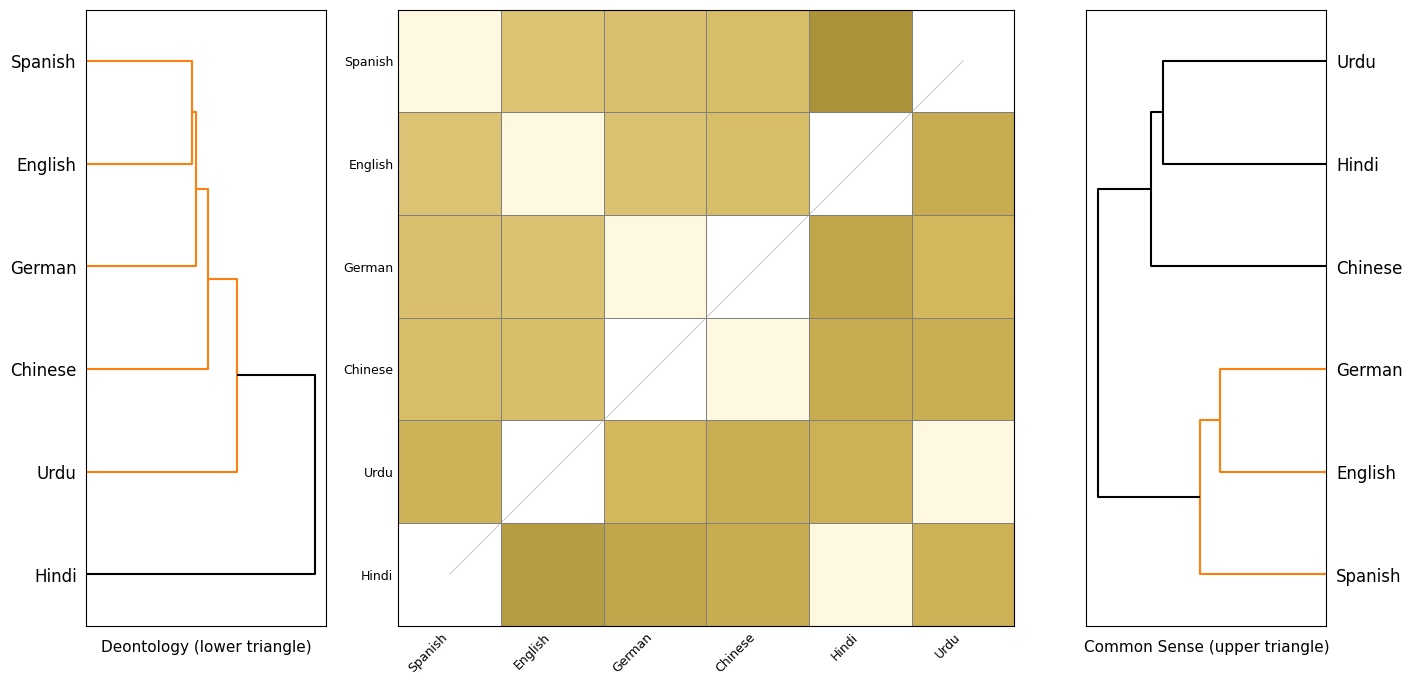

Plotting util vs justice


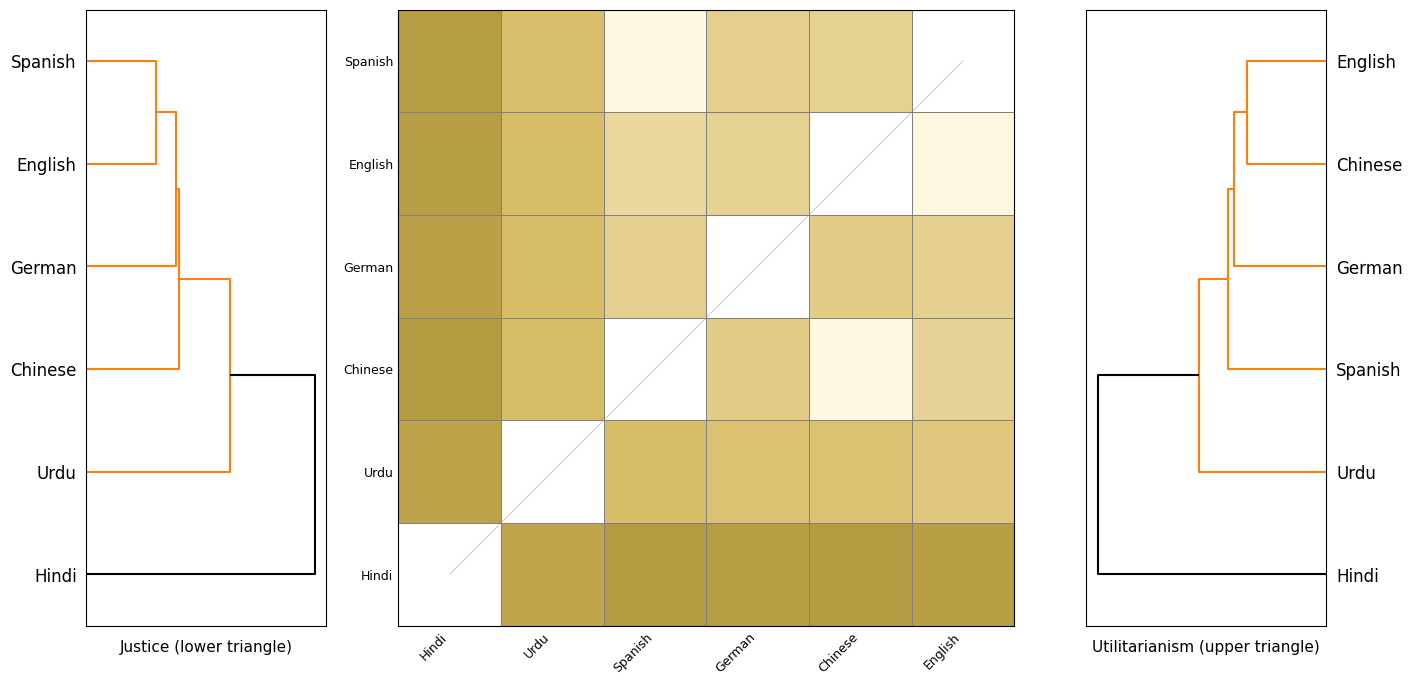

Plotting virtue vs meq


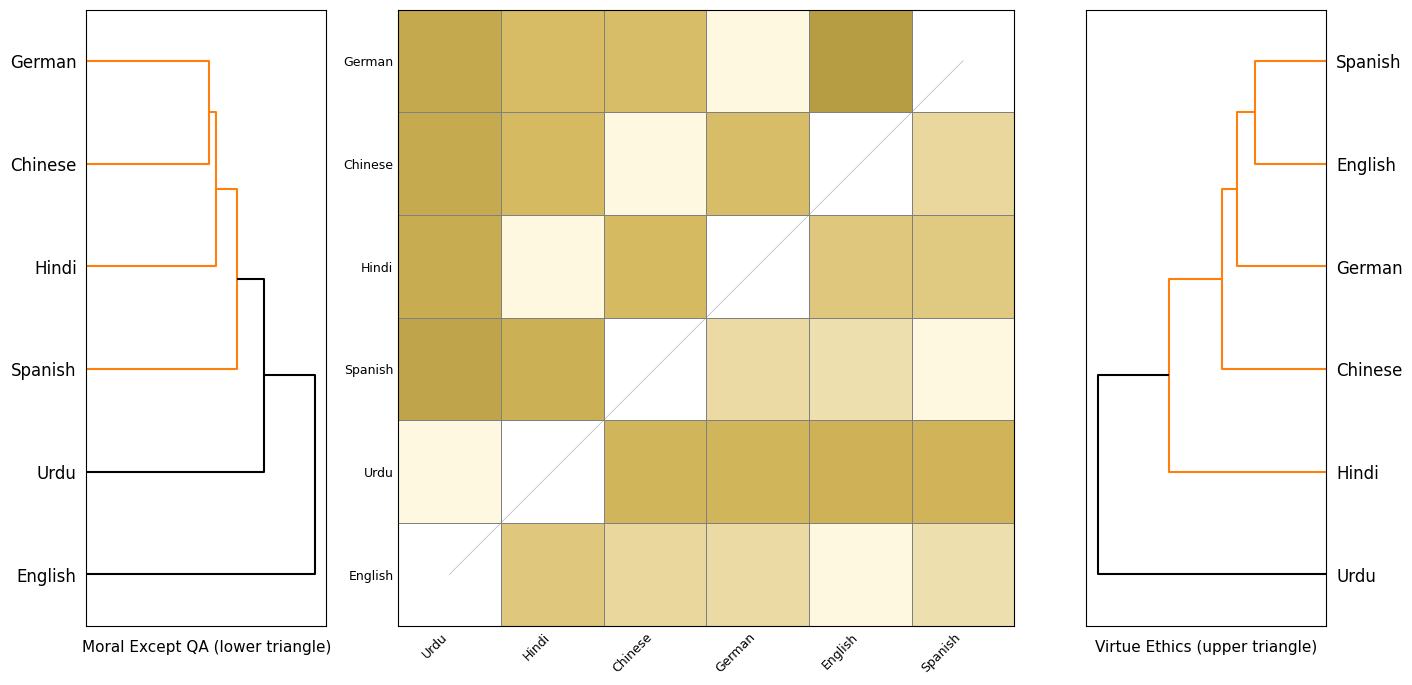

In [55]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram
from scipy.spatial.distance import squareform

# -------------------------------
# custom colormap (light → gold → dark gold)
# -------------------------------
cmap_custom = LinearSegmentedColormap.from_list(
    "golden", ["#fff8e1", "#d4b75c", "#87721C"]
)

# -------------------------------
# disagreement matrix
# -------------------------------
def disagreement_matrix_symmetric(df, lang_cols):
    n = len(lang_cols)
    mat = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            disagreements = (df[lang_cols[i]] != df[lang_cols[j]]) & \
                            df[lang_cols[i]].notna() & df[lang_cols[j]].notna()
            total = df[lang_cols[i]].notna() & df[lang_cols[j]].notna()
            score = disagreements.sum() / total.sum() if total.sum() > 0 else np.nan
            mat[i, j] = mat[j, i] = score
    return mat

# -------------------------------
# rebuild all_matrices from ETHICS + MEQ
# -------------------------------
all_matrices = {}
data_dirs = {
    "ethics": "ETHICS_combined_results",
    "meq": "MEQ_combined_results"
}

for source, combined_dir in data_dirs.items():
    if not os.path.exists(combined_dir):
        continue

    for fname in os.listdir(combined_dir):
        if not fname.endswith("_predictions_combined.csv"):
            continue
        df = pd.read_csv(os.path.join(combined_dir, fname))
        lang_cols = [c for c in df.columns if c not in ["question", "reference"]]
        if not lang_cols:
            continue
        mat = disagreement_matrix_symmetric(df, lang_cols)
        mat_df = pd.DataFrame(mat, index=lang_cols, columns=lang_cols)
        base = fname.replace("_predictions_combined.csv", "")
        parts = base.split("_")
        paradigm = parts[0].lower()  # lowercase for matching
        model = "_".join(parts[1:])
        all_matrices.setdefault(paradigm, {})[model] = mat_df

# -------------------------------
# mapping shorthand → full paradigm names
# -------------------------------
paradigm_labels = {
    "den": "Deontology",
    "cms": "Common Sense",
    "util": "Utilitarianism",
    "justice": "Justice",
    "virtue": "Virtue Ethics",
    "meq": "Moral Except QA"
}

# -------------------------------
# split clustered heatmap with two dendros
# -------------------------------
def plot_split_heatmap_with_existing_dendrogram_logic(
    df1, df2, paradigm1, paradigm2, method="ward",
    cmap=cmap_custom, vmin=0, vmax=1
):
    """
    Split clustered heatmap with dendrograms:
    - Left dendrogram = paradigm2 (lower triangle)
    - Right dendrogram = paradigm1 (upper triangle)
    Paradigm names shown at the bottom with clarification.
    """

    # --- row clustering (paradigm2)
    condensed2 = squareform(df2.values)
    Z2 = linkage(condensed2, method=method)
    row_order = leaves_list(Z2)

    # --- col clustering (paradigm1)
    condensed1 = squareform(df1.values)
    Z1 = linkage(condensed1, method=method)
    col_order = leaves_list(Z1)

    # --- keep original labels for dendrograms (so they match consolidated plots)
    row_labels = df2.index
    col_labels = df1.index

    # --- reorder matrices for the heatmap using leaf orders
    mat1 = df1.values[row_order, :][:, col_order]
    mat2 = df2.values[row_order, :][:, col_order]

    mat = np.full_like(mat1, np.nan, dtype=float)
    mat[np.triu_indices_from(mat, k=1)] = mat1[np.triu_indices_from(mat1, k=1)]
    mat[np.tril_indices_from(mat, k=-1)] = mat2[np.tril_indices_from(mat2, k=-1)]
    np.fill_diagonal(mat, np.nan)

    row_labels_ordered = df2.index[row_order]
    col_labels_ordered = df1.index[col_order]

    # --- figure layout
    fig = plt.figure(figsize=(16, 8))
    gs = fig.add_gridspec(1, 3, width_ratios=[2, 6, 2], wspace=0.05)

    # left dendrogram (paradigm2, keep original labels)
    ax_left = fig.add_subplot(gs[0, 0])
    dendrogram(
        Z2, labels=row_labels, orientation="right", ax=ax_left,
        above_threshold_color="k", color_threshold=None
    )
    ax_left.set_xticks([])
    ax_left.set_xlabel(
        f"{paradigm_labels.get(paradigm2, paradigm2)} (lower triangle)",
        fontsize=11, labelpad=10
    )

    # heatmap (reordered)
    ax_matrix = fig.add_subplot(gs[0, 1])
    im = ax_matrix.pcolormesh(
        mat, cmap=cmap, vmin=vmin, vmax=vmax,
        edgecolors="gray", linewidth=0.5
    )

    # diagonal separator (aligned with cell centers)
    ax_matrix.plot(
        np.arange(len(row_labels_ordered)) + 0.5,
        np.arange(len(col_labels_ordered)) + 0.5,
        color="gray", linewidth=0.6, alpha=0.5
    )

    # ticks & labels
    ax_matrix.set_xticks(np.arange(len(col_labels_ordered)) + 0.5)
    ax_matrix.set_yticks(np.arange(len(row_labels_ordered)) + 0.5)
    ax_matrix.set_xticklabels(col_labels_ordered, rotation=45, ha="right", fontsize=9)
    ax_matrix.set_yticklabels(row_labels_ordered, fontsize=9)
    ax_matrix.tick_params(axis="both", which="both", length=0)

    # keep square aspect
    ax_matrix.set_aspect("equal")

    # right dendrogram (paradigm1, keep original labels)
    ax_right = fig.add_subplot(gs[0, 2])
    dendrogram(
        Z1, labels=col_labels, orientation="left", ax=ax_right,
        above_threshold_color="k", color_threshold=None
    )
    ax_right.set_xticks([])
    ax_right.set_xlabel(
        f"{paradigm_labels.get(paradigm1, paradigm1)} (upper triangle)",
        fontsize=11, labelpad=10
    )

    plt.show()


# -------------------------------
# Run for paradigm pairs
# -------------------------------
pairs = [
    ("cms", "den"),
    ("util", "justice"),
    ("virtue", "meq"),
]

for p1, p2 in pairs:
    if p1 not in all_matrices or p2 not in all_matrices:
        print(f"Skipping {p1} vs {p2}")
        continue
    df1 = list(all_matrices[p1].values())[0]
    df2 = list(all_matrices[p2].values())[0]
    common_langs = set(df1.index) & set(df2.index)
    if not common_langs:
        print(f"No common languages for {p1} vs {p2}")
        continue
    common_langs = sorted(common_langs)
    df1 = df1.loc[common_langs, common_langs]
    df2 = df2.loc[common_langs, common_langs]
    print(f"Plotting {p1} vs {p2}")
    plot_split_heatmap_with_existing_dendrogram_logic(df1, df2, p1, p2)

